In [1]:
import os 
import numpy as np
import pandas as pd
path = r'D:\mypkgs\backtest\data_mock'

# 数据分析

In [2]:
df_data = pd.read_pickle(os.path.join(path, 'cbmkt.pickle'))
df_data.reset_index(inplace=True)
df_data['date'] = pd.to_datetime(df_data['date'])
df_data.tail()

,date,windcode,转债余额,成交量,成交额,成交额_净价,最高价,最低价,开盘价,收盘价
421843,2023-05-08,128140.SZ,10.893835,50651100.0,94973126.6,9.476081e+07,189.8808,182.5808,189.8458,187.7178
421844,2023-05-08,128141.SZ,12.701455,19859500.0,24853729.3,2.477592e+07,125.2152,124.4972,124.5092,124.6332
421845,2023-05-08,128142.SZ,7.179734,40435900.0,49713314.9,4.955600e+07,123.2080,121.9110,122.8950,122.6110
421846,2023-05-08,128143.SZ,2.439694,2969000.0,3561457.0,3.549646e+06,119.9312,119.3032,119.7532,119.4722
421847,2023-05-08,128144.SZ,9.793808,8380000.0,9786963.7,9.774290e+06,117.0238,115.9748,115.9748,116.9488


In [3]:
df_data['label'] = 1
df_data.isnull().sum()

date          0
windcode      0
转债余额        599
成交量         599
成交额         599
成交额_净价        8
最高价           8
最低价           8
开盘价           8
收盘价           8
label         0
dtype: int64

## 可转债交易日

1. 可转债交易日暂时使用cbmkt字段date的并集替代
2. 可以单独维护一个可转债交易日的数据

In [4]:
trade_dates = pd.Series(np.sort(df_data['date'].unique()))
trade_dates.tail(12)

4686   2023-04-18
4687   2023-04-19
4688   2023-04-20
4689   2023-04-21
4690   2023-04-24
4691   2023-04-25
4692   2023-04-26
4693   2023-04-27
4694   2023-04-28
4695   2023-05-04
4696   2023-05-05
4697   2023-05-08
dtype: datetime64[ns]

## 成交量缺失

In [5]:
l_amount_nan = df_data['成交额'].isnull()
l_volume_nan = df_data['成交量'].isnull()
l_amount_zero = df_data['成交额'] == 0
l_volume_zero = df_data['成交量'] == 0
l_zzye_nan = df_data['转债余额'].isnull()

In [6]:
print("转债余额与成交量缺失值一致")
sum(l_volume_nan != l_zzye_nan)

转债余额与成交量缺失值一致


0

In [7]:
print("成交额缺失  则  成交量缺失或成交量为0")
sum(l_amount_nan & (~(l_volume_nan | l_volume_zero)))

成交额缺失  则  成交量缺失或成交量为0


0

In [8]:
print("成交额与成交量信息一致")
sum((l_amount_nan | l_amount_zero) != (l_volume_nan | l_volume_zero))

成交额与成交量信息一致


0

## 价格缺失

In [9]:
print('开始与结束均有空值')
df_data.query("windcode == '128078.SZ'")

开始与结束均有空值


,date,windcode,转债余额,成交量,成交额,成交额_净价,最高价,最低价,开盘价,收盘价,label
109678,2019-10-21,128078.SZ,10.000000,0.0,0.0,0.0,99.9989,99.9989,99.9989,99.9989,1
109863,2019-10-22,128078.SZ,10.000000,0.0,0.0,0.0,99.9978,99.9978,99.9978,99.9978,1
110049,2019-10-23,128078.SZ,10.000000,0.0,0.0,0.0,99.9967,99.9967,99.9967,99.9967,1
110236,2019-10-24,128078.SZ,10.000000,0.0,0.0,0.0,99.9956,99.9956,99.9956,99.9956,1
110423,2019-10-25,128078.SZ,10.000000,0.0,0.0,0.0,99.9945,99.9945,99.9945,99.9945,1
...,...,...,...,...,...,...,...,...,...,...,...
416728,2023-04-19,128078.SZ,0.006643,0.0,0.0,0.0,212.0002,212.0002,212.0002,212.0002,1
417236,2023-04-20,128078.SZ,0.006643,0.0,0.0,0.0,211.9961,211.9961,211.9961,211.9961,1
417744,2023-04-21,128078.SZ,0.006643,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,1
418252,2023-04-24,128078.SZ,0.006643,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,1


1. 价格缺失可认为当天没有交易（成交量为0或者nan）
2. 价格缺失可填充方案
    1. 优先用同期其它价格填充
    2. 如果还是缺失，则用前收盘填充

In [10]:
l_close_nan = df_data['收盘价'].isnull()
l_price_nan = df_data[['开盘价', '最高价', '最低价']].isnull().any(axis=1)
l_price_nan_all = df_data[['开盘价', '最高价', '最低价']].isnull().all(axis=1)

In [11]:
print("收盘价缺失  则  成交量缺失或成交量为0")
sum(l_close_nan & (~(l_volume_nan | l_volume_zero)))

收盘价缺失  则  成交量缺失或成交量为0


0

In [12]:
print("开高低缺失值信息一致")
sum(l_price_nan != l_price_nan_all)

开高低缺失值信息一致


0

In [13]:
print("价格缺失  与  收盘价缺失不等的情况较少")
sum(l_price_nan != l_close_nan)

价格缺失  与  收盘价缺失不等的情况较少


0

In [14]:
df_data.loc[l_close_nan != l_price_nan]

,date,windcode,转债余额,成交量,成交额,成交额_净价,最高价,最低价,开盘价,收盘价,label


## vwap复权因子

1. 成交额/成交量得到的是当日未复权的vwap价格，需要复权因子才能计算出复权的vwap
2. 复权因子计算可以用当日复权收盘价/当日收盘价计算得到
3. 除了复权因子， 有一些异常数据如’125002.SZ	2004-01-02‘有整数倍的误差

In [15]:
df_data['vwap'] = 100*df_data['成交额_净价']/df_data['成交量']

In [16]:
l1 = df_data['vwap'] > df_data['最高价']
l2 = df_data['vwap'] < df_data['最低价']
print('vwap异常数量：')
print(sum(l1 | l2))

vwap异常数量：
2682


In [17]:
df_data.loc[l1 | l2,['windcode', 'date', '收盘价', 'vwap', '开盘价', '最高价', '最低价']]

,windcode,date,收盘价,vwap,开盘价,最高价,最低价
6,125002.SZ,2004-01-02,116.5816,11.629270,114.7416,117.3416,114.6216
7,125629.SZ,2004-01-02,129.1481,13.033300,131.0481,131.5781,128.6181
10,125930.SZ,2004-01-02,101.9474,103.075820,101.7574,102.2674,101.7474
11,125936.SZ,2004-01-02,98.2164,98.766870,98.1564,98.3364,98.0564
18,125002.SZ,2004-01-05,123.0693,12.225332,116.7693,123.6193,116.7693
...,...,...,...,...,...,...,...
384795,127077.SZ,2023-01-10,129.9671,129.967123,129.9671,129.9671,129.9671
405576,123175.SZ,2023-03-17,129.9803,129.980274,129.9803,129.9803,129.9803
407058,123176.SZ,2023-03-22,129.9885,129.988493,129.9885,129.9885,129.9885
415595,123182.SZ,2023-04-17,129.9778,129.977808,129.9778,129.9778,129.9778


## 数据缺失

In [18]:
df_info = df_data.loc[~l_close_nan].groupby('windcode')['date'].agg(['min', 'max'])
date_set = df_info.apply(
    lambda x: pd.Series(pd.date_range(x['min'], x['max'])),
    axis=1).stack().reset_index()

date_set.columns = ['windcode', 'id', 'date']
del date_set['id']
date_set = date_set.query("date in @trade_dates")

In [19]:
df_data = pd.merge(date_set, df_data, how='left', on=['windcode', 'date'])

In [20]:
print('数据缺失量')
df_data['label'].isnull().sum()

数据缺失量


180

In [21]:
df_data.query("label != label").tail()

,windcode,date,转债余额,成交量,成交额,成交额_净价,最高价,最低价,开盘价,收盘价,label,vwap
365421,128050.SZ,2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365422,128050.SZ,2022-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383844,128079.SZ,2019-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410411,128127.SZ,2021-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410412,128127.SZ,2021-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_data.query("label != label")['date'].value_counts()

2022-08-02    16
2022-08-11    14
2022-01-05    13
2022-01-07    12
2022-01-14    10
2022-01-17    10
2022-01-06     9
2022-01-10     8
2022-01-11     8
2022-01-12     8
2022-01-13     8
2019-11-19     6
2022-01-18     6
2022-01-19     6
2022-01-20     5
2021-12-20     4
2021-12-31     3
2021-12-17     3
2022-01-21     3
2022-04-07     3
2022-01-25     2
2022-01-26     2
2022-02-07     2
2022-01-28     2
2022-01-27     2
2022-01-24     2
2022-07-27     1
2021-12-29     1
2014-06-09     1
2014-06-06     1
2021-12-30     1
2021-12-27     1
2021-12-28     1
2021-12-24     1
2021-12-23     1
2022-07-26     1
2021-12-13     1
2022-07-15     1
2014-06-10     1
Name: date, dtype: int64

In [23]:
df_data.query("label != label")['windcode'].value_counts()

123029.SZ    24
118004.SH    16
127052.SZ    13
123133.SZ    12
113638.SH    12
113637.SH    11
123135.SZ    10
110084.SH     9
123134.SZ     9
113653.SH     4
110034.SH     3
128050.SZ     3
128003.SZ     3
123053.SZ     3
118014.SH     3
113052.SH     3
113652.SH     2
123074.SZ     2
113009.SH     2
127067.SZ     2
127014.SZ     2
123153.SZ     2
123152.SZ     2
113061.SH     2
128127.SZ     2
118015.SH     2
113651.SH     2
118016.SH     1
123154.SZ     1
128079.SZ     1
110061.SH     1
113655.SH     1
127066.SZ     1
127065.SZ     1
113043.SH     1
118010.SH     1
118011.SH     1
118017.SH     1
118012.SH     1
118013.SH     1
110060.SH     1
113546.SH     1
113654.SH     1
123081.SZ     1
113548.SH     1
113650.SH     1
123132.SZ     1
Name: windcode, dtype: int64

### 扣除头尾收盘价缺失数据后缺失值大量减少

In [24]:
df_data.isnull().sum()

windcode        0
date            0
转债余额          779
成交量           779
成交额           779
成交额_净价        180
最高价           180
最低价           180
开盘价           180
收盘价           180
label         180
vwap        22258
dtype: int64

# 数据清洗过程

In [25]:
df_data = pd.read_pickle(os.path.join(path, 'cbmkt.pickle'))
df_data.reset_index(inplace=True)
df_data['date'] = pd.to_datetime(df_data['date'])
df_data.shape

(421848, 10)

In [26]:
trade_dates = pd.Series(np.sort(df_data['date'].unique()))

In [27]:
# 用成交量判断当日是否有交易， 选择每一个标的当日有交易的最大与最小日期
l_nan = df_data['成交量'].isnull() | (df_data['成交量'] == 0)
df_info = df_data.loc[~l_nan].groupby(
    'windcode')['date'].agg(['min', 'max'])

# 如果标的数据最新有数据，哪怕是停牌数据，也要暂认为标的处于存续期
# 如果不想添加这个逻辑可以把以下三行代码注释掉
max_date = df_data.groupby('windcode')['date'].max()
secu_subsist = max_date.index[max_date == trade_dates.max()]
df_info.loc[secu_subsist.intersection(df_info.index), 'max'] = max_date

In [28]:
date_set = df_info.apply(
    lambda x: pd.Series(pd.date_range(x['min'], x['max'])),
    axis=1).stack().reset_index()

date_set.columns = ['windcode', 'id', 'date']
del date_set['id']
date_set = date_set.query("date in @trade_dates")

In [29]:
cols = ['windcode', 'date', '开盘价', '最高价', '最低价', '收盘价', '成交量', '成交额']
df_data = pd.merge(date_set, df_data[cols], how='left', on=['windcode', 'date'])

In [30]:
# 量额用0填充缺失值
cols = ['成交量', '成交额']
df_data[cols] = df_data[cols].fillna(0)

# 如果收盘价缺失， 则开、高、低数据无效
l_close_nan = df_data['收盘价'].isnull()
df_data.loc[l_close_nan, ['开盘价', '最高价', '最低价']] = np.nan

# 收盘用前值填充缺失值
df_data['收盘价'] = df_data.groupby(
    'windcode')['收盘价'].fillna(method='ffill')

# 开、高、 低用受安排填缺失值
for col in ['开盘价', '最高价', '最低价']:
    df_data[col] = df_data[col].fillna(df_data['收盘价'])
    
df_data.isnull().sum()

windcode    0
date        0
开盘价         0
最高价         0
最低价         0
收盘价         0
成交量         0
成交额         0
dtype: int64

In [31]:
print('开始与结束均有空值')
df_data.query("windcode == '128078.SZ'")

开始与结束均有空值


,windcode,date,开盘价,最高价,最低价,收盘价,成交量,成交额
365929,128078.SZ,2019-11-08,117.4792,121.8792,116.9992,120.1792,6.375121e+08,7.618980e+08
365930,128078.SZ,2019-11-11,119.5459,121.8639,119.5459,120.7259,1.188741e+08,1.436794e+08
365931,128078.SZ,2019-11-12,121.0948,121.3748,118.4848,120.5948,3.760050e+07,4.496918e+07
365932,128078.SZ,2019-11-13,119.4397,120.8737,119.4397,120.6337,2.902540e+07,3.490675e+07
365933,128078.SZ,2019-11-14,120.1726,123.7526,119.4726,123.4726,3.023550e+07,3.659758e+07
...,...,...,...,...,...,...,...,...
366759,128078.SZ,2023-04-11,193.2890,200.8390,188.2070,192.3840,5.015484e+08,9.816364e+08
366760,128078.SZ,2023-04-12,193.2849,208.7849,190.4849,203.6849,1.071524e+09,2.180152e+09
366761,128078.SZ,2023-04-13,203.0968,210.7428,198.5548,200.9548,6.040599e+08,1.235554e+09
366762,128078.SZ,2023-04-14,202.2727,211.2567,198.2867,203.4987,5.172054e+08,1.060896e+09


In [32]:
df_data.shape

(403677, 8)

# 其它数据

In [33]:
df_data = pd.read_pickle('./data/not_include_list.pickle')
df_data[:5]

[('20171229', '113502.SH'),
 ('20180102', '113502.SH'),
 ('20180102', '113503.SH'),
 ('20180103', '113502.SH'),
 ('20180103', '113503.SH')]

In [34]:
f = pd.DataFrame(df_data, columns=['date', 'windcode'])

In [35]:
f.query("windcode == '110038.SH'")

,date,windcode
120,20180601,110038.SH
123,20180604,110038.SH
126,20180605,110038.SH
129,20180606,110038.SH
133,20180607,110038.SH
137,20180608,110038.SH
141,20180611,110038.SH
145,20180612,110038.SH
149,20180613,110038.SH
153,20180614,110038.SH


In [36]:
zzeq = pd.read_pickle('./data/zzeq.pickle')
zzeq.head()

date
20121008    1.000065
20121009    1.006255
20121010    1.006772
20121011    1.006590
20121012    1.006184
Name: 转债等权指数, dtype: float64

<Axes: xlabel='date'>

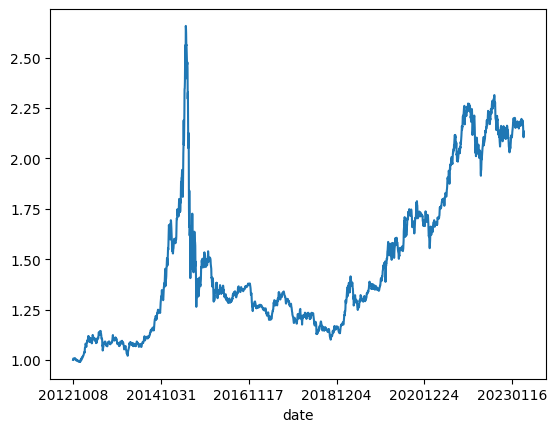

In [37]:
zzeq.plot()